# Introduction

In this notebook, I take the data I merged and cleaned in the Data Wrangling notebook, and use it to tell a story about crime levels on and around the Georgia Tech campus. How have overall crime levels changed over the years? Which types of crime are more likely on certain locations of campus? During certain times of day or year? These are just a few of the questions I look to answer in this notebook with the goal of using these insights to improve the final forecasts of number of crimes. I begin by importing the data, then look into location-based crime trends, and then temporal crime trends. I end by performing further statistical analysis on which variables can be used to predict crime levels for each month.

# Importing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import scipy.stats as stats
import mplleaflet
%matplotlib inline

#setting matplotlib parameters and color palette
plt.style.use('seaborn')
p = sns.color_palette('Paired', n_colors=12)
palette = [c for c in p[1::2]] + [c for c in p[::2]]
sns.set_palette(palette)
params = {'axes.titlesize':'20',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
         'axes.labelsize': '14',
         'legend.fontsize': '14'}
mpl.rcParams.update(params)

In [2]:
c = pd.read_csv('../Data/crime_data_clean.csv', index_col='time', parse_dates=True)

#labels for use in plots
semester_names = ['spring', 'summer', 'fall']
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


#setting semester as categorical datatype to maintain correct order
c['semester'] = c['semester'].astype(pd.api.types.CategoricalDtype(
    categories=semester_names, ordered=True))

c.head()

,code,description,disposition,location,patrol_zone,landmark,lat,long,year,month,...,inc_15_25,inc_25_35,inc_35_50,inc_50_75,inc_75_100,inc_100_150,inc_150_200,inc_greater_200,inc_median,inc_mean
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:36:00,7399,Miscellaneous Offenses,NaN,NONCAM,Z4,NaN,33.773124,-84.403163,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 01:55:00,7399,Miscellaneous Offenses,NaN,ONCAMRES,Z1,Center Street Apartments North,0.000000,0.000000,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 02:00:00,2308,Larceny - From Building,NaN,NONCAM,Z2,Sigma Nu Fraternity,33.775556,-84.394180,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-01 12:00:00,2204,Burglary - No Forced Entry - Residence,Unfounded,ONCAMRES,Z2,North Avenue Apartments North Building,33.771292,-84.391332,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299
2010-01-02 06:15:00,7399,Miscellaneous Offenses,NaN,ONCAM,Z2,North Avenue Apartments,33.771292,-84.391332,2010,1,...,18772,18419,21725,26366,16067,18490,8005,14504,45171,79299


# Location-Based Crime Trends

In [3]:
#making a dataframe with all the unique locations crimes have occurred
map_df = c[(c.long!=0)&(c.lat!=0)].drop_duplicates(subset=['lat', 'long'])

#plotting on a map by patrol zone
fig = plt.figure(figsize=(5,8))
for zone, group in map_df.groupby('patrol_zone'):
    #if zone != 'Z3':
        plt.plot(group.long, group.lat, ls='', marker='D', markersize=10)
    
mplleaflet.display(fig = fig)

#Patrol Zone Legend:
#blue - OFFCAM
#green - Z1
#red - Z2
#orange - Z3
#purple - Z4

NOTE: The above interactive map may not render on GitHub. If so, it can be viewed here:

https://nbviewer.jupyter.org/github/pspratling/GT-Crime-Data-Analysis/blob/master/Project/Exploratory%20Data%20Analysis.ipynb

Clearly over the years, crime has occurred almost everywhere on and around campus. But are some locations safer than others? Let's find out which crimes are more prevalent in different locations on and around campus.

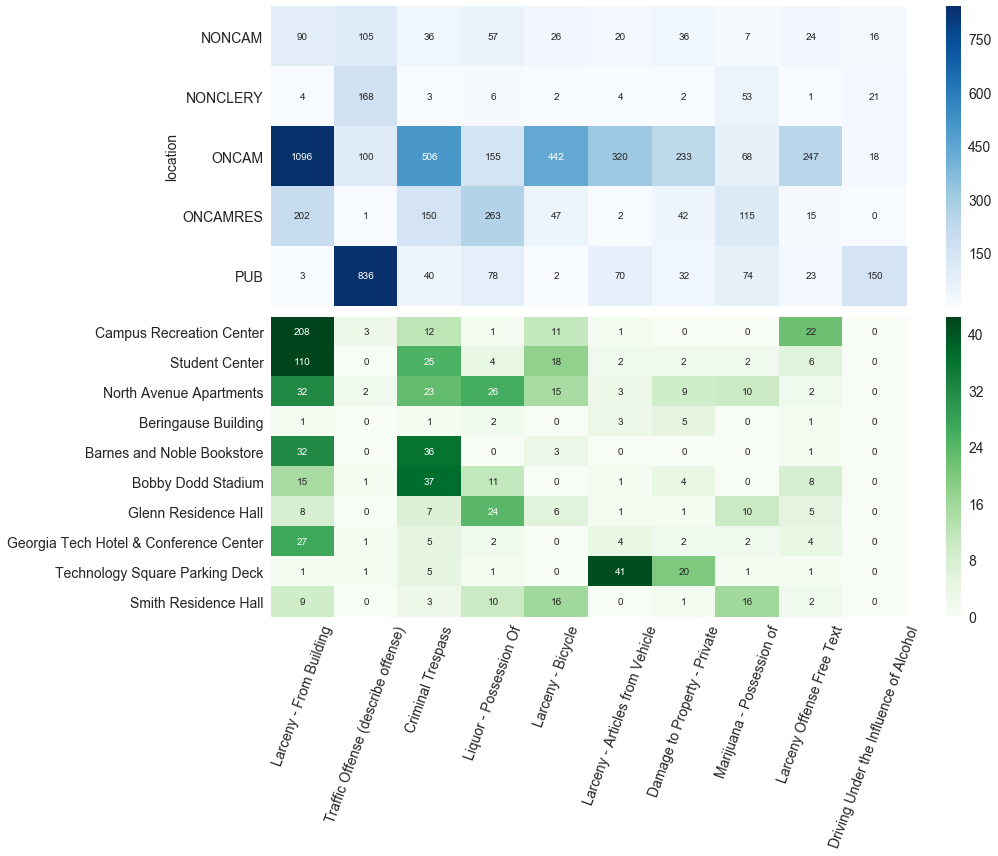

In [4]:
#finding top 10 most frequent crimes and landmarks (excluding miscellaneous offenses)
top_crimes = c['description'].value_counts()[1:11].index
top_landmarks = c['landmark'].value_counts()[:10].index

#grouping c and reshaping for analysis
crime_location = c.groupby(['location', 'description']).size().unstack().fillna(0)
crime_landmark = c.groupby(['landmark', 'description']).size().unstack().fillna(0)

#filtering by most common crimes and landmarks
crime_location = crime_location.loc[:, top_crimes]
crime_landmark = crime_landmark.loc[top_landmarks, top_crimes]

#plotting heatmaps
fig, axes = plt.subplots(2, 1, figsize=(15, 12))   
sns.heatmap(crime_location, cmap='Blues', ax=axes[0], robust=True, xticklabels=False, annot=True, fmt='g')
sns.heatmap(crime_landmark, cmap='Greens', ax=axes[1], robust=True, annot=True, fmt='g')
axes[0].set_xlabel('')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

It seems that most crimes are being reported on campus as opposed to in the surrounding areas or in residential areas. Larceny is very prevalent throughout campus, happening frequently in the Student Center and the CRC in particular. The absence of the CULC is interesting to note - despite being one of the most popular locations for students to be on campus, it is not even in the top 10 highest locations for crime. This could be because of the active security guards always on location.

Larceny from vehicle and damage to property appears to be overwhelmingly in the Tech Square Parking Deck as opposed to the many other parking locations on campus. This might be because of the public access to this parking deck. It may be a good idea to choose another location to park on campus, even if this one is conveniently located.

Residential areas seem to be fairly safe. Larceny and criminal trespass seem to occur occasionally, but the most frequent crime occurring in these areas appears to be illegal possession of drugs (alcohol and marijuana).

# Temporal Crime Trends

How has the overall level of crime changed over the years? What is the relationship between crime and time of day? By the day of week? By quarter or semester?

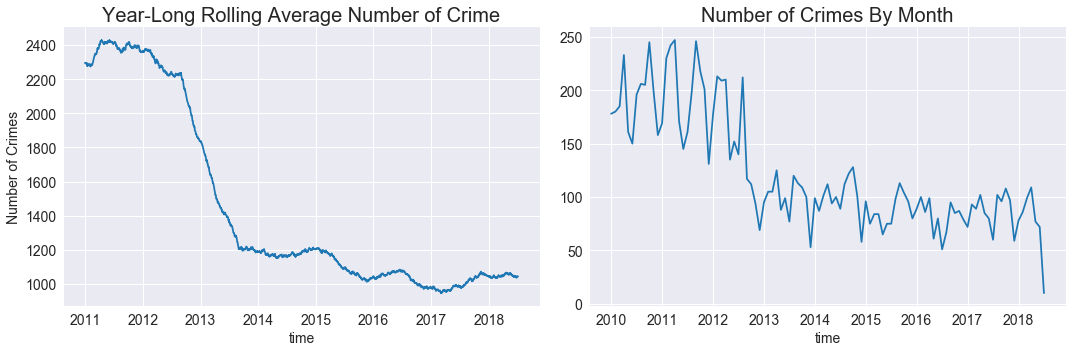

In [5]:
#plotting year long rolling average of number of crimes and number of crimes per month
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
c.resample('D').size().rolling(365).sum().plot(ax=ax[0])
c.resample('M').size().plot(ax=ax[1])
ax[0].set_ylabel('Number of Crimes')
ax[0].set_title('Year-Long Rolling Average Number of Crime')
ax[1].set_title('Number of Crimes By Month')
plt.tight_layout()
plt.show()

Overall levels of crime have clearly decreased over time. There is also clearly some major periodicity as shown in the right chart that implies that seasonality plays a large role in number of crimes. 

The major decrease in total number of crimes sometime between 2012 and 2014 is very interesting. This is something we will want to investigate later.

It might be interesting to see how individual types of crime have changed over the years and throughout the day.

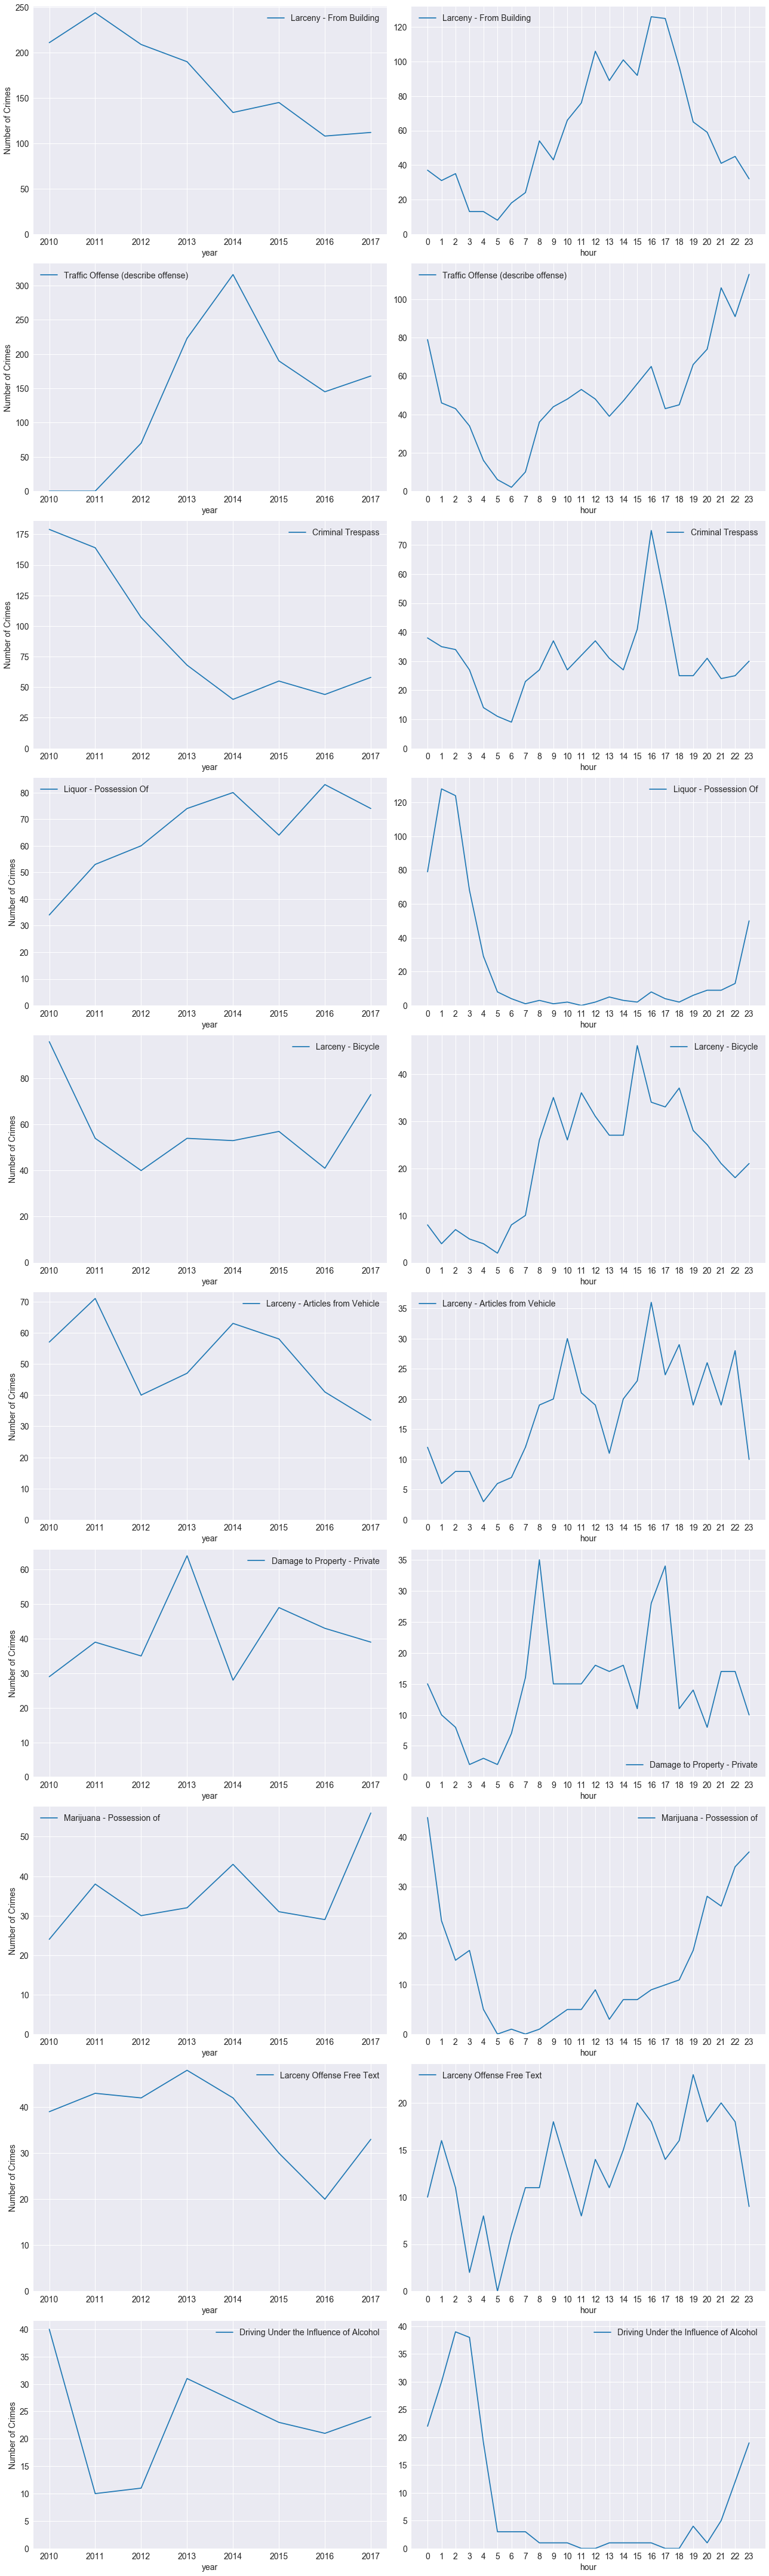

In [6]:
fig, ax = plt.subplots(10, 2, figsize=(18,60))
#grouping by top crimes and time
crime_year = c.groupby(['description', 'year']).size().unstack().fillna(0)
crime_hour = c.groupby(['description', 'hour']).size().unstack().fillna(0)
crime_year = crime_year.loc[top_crimes].drop(columns=2018)
crime_hour = crime_hour.loc[top_crimes]

#plotting each crime side-by-side:
#left: crime trend over the year
#right: crime trend through the day
for i in range(10):
    crime_year.iloc[i].plot(ax=ax[i, 0], legend=True)
    crime_hour.iloc[i].plot(ax=ax[i, 1], legend=True, xticks=range(24))
    ax[i, 0].set_ylim(ymin=0)
    ax[i, 1].set_ylim(ymin=0)
    ax[i, 0].set_ylabel('Number of Crimes')
    
plt.tight_layout()
plt.show()

Larceny and criminal trespass have clearly gone down throughout the years. Other crimes such as possession of liquor and driving under the influence of alcohol appear to have remained fairly consistent.

It is also interesting to see that larceny and criminal trespass appear to peak sometime in the mid afternoon, whereas DUI's and crimes that are likely to occur in residences (possession of liquor/marijuana) seem to be highest in the late night/early morning.

Let's look how overall crime rates change by time of day/ year/ week.

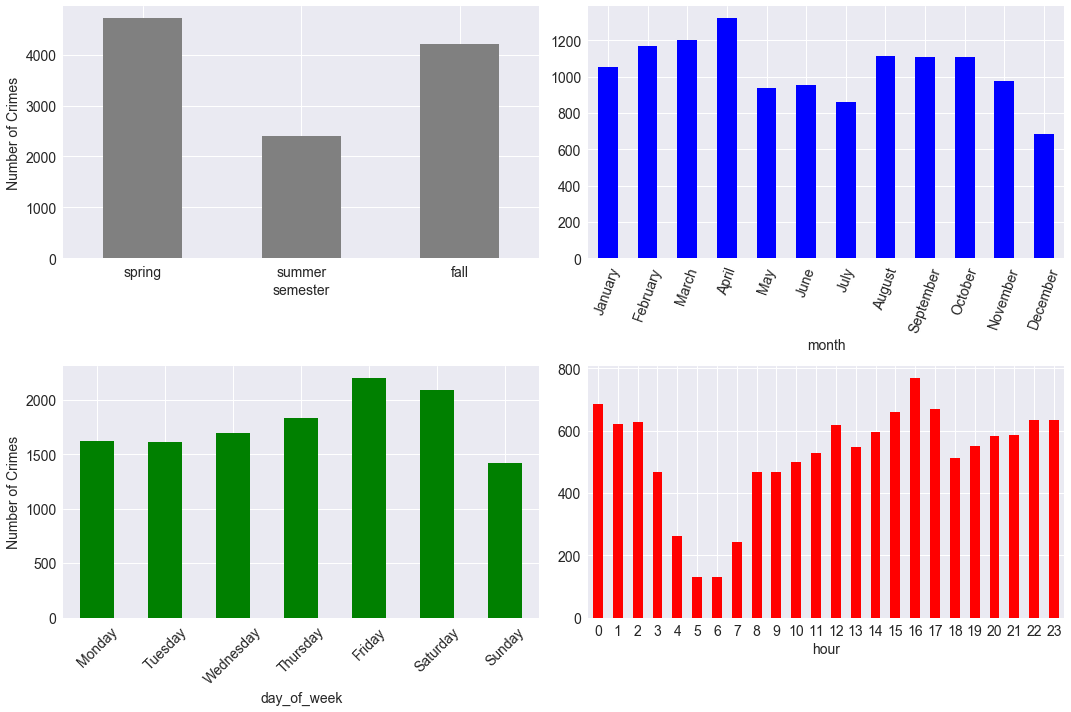

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
#grouping and plotting
c.groupby('semester').size().plot(kind='bar', ax=ax[0, 0], color='gray', rot=0)
c.groupby('month').size().plot(kind='bar', ax=ax[0, 1], color='b', rot=70)
c.groupby('day_of_week').size().plot(kind='bar', ax=ax[1, 0], color='g', rot=45)
c.groupby('hour').size().plot(kind='bar', ax=ax[1, 1], color='r', rot=0)

#formatting plot
ax[0, 1].set_xticklabels(month_names)
ax[1, 0].set_xticklabels(dow_names)
ax[0, 0].set_ylabel('Number of Crimes')
ax[1, 0].set_ylabel('Number of Crimes')
plt.tight_layout()
plt.show()

Crimes clearly decrease as a result of less students being on campus. This is shown in the decrease in crimes in May-July during the summer semester, as well as in December when many students go home for winter break.

Crimes seem to peak on Friday and Saturday, with the weekdays being fairly consistent and Sunday having the least amount. Crimes also have a major decrease in the early morning around 4-7, and are fairly consistent throughout the evening and late night.

Let's try to find out if crime distribution throughout the day differs by day of week.

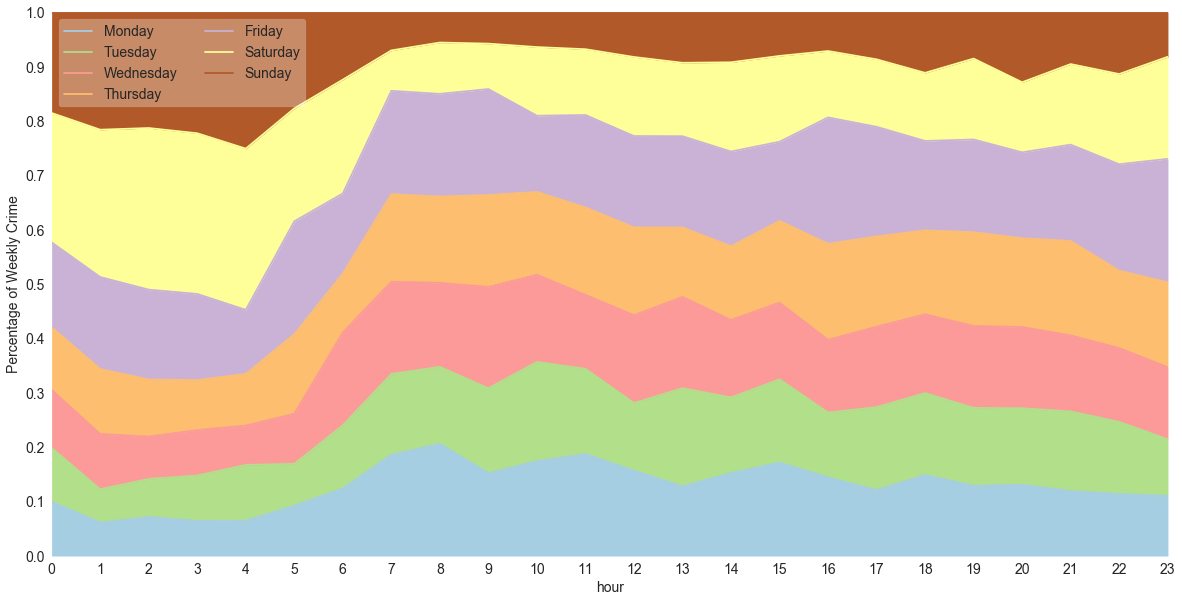

In [8]:
#grouping and reshaping
hour_dow = c.groupby(['day_of_week', 'hour']).size().unstack(0)
#finding percentages
hour_dow = hour_dow.divide(hour_dow.sum(axis=1), axis=0)

#plotting 100% area chart
fig, ax = plt.subplots(figsize=(20,10))
hour_dow.plot(kind='area', ax=ax, colormap='Paired')
ax.set_xticks(range(24))
ax.set_yticks(np.linspace(0, 1, 11))
ax.legend(dow_names, ncol=2, facecolor='w', framealpha=.3, frameon=True)
ax.set_xlim(0, 23)
ax.set_ylim(0, 1)
ax.set_ylabel('Percentage of Weekly Crime')

plt.show()

Clearly crimes on the weekend tend to happen later at night than on the weekdays. Also interesting to note is that the majority of Sunday's crimes are in the late night, i.e. from Saturday after midnight. Once Sunday morning comes, the crimes appear to stay low for the rest of the day, making Sunday the safest day by far.

# Crimes by Month - Further Exploration and Statistical Analysis

Since we will be predicting crimes by month, we should look a little deeper in how the number changes per month. How do crimes vary by month? Which variables correlate strongly with crimes per month? Does crimes per month have significant autocorrelation?

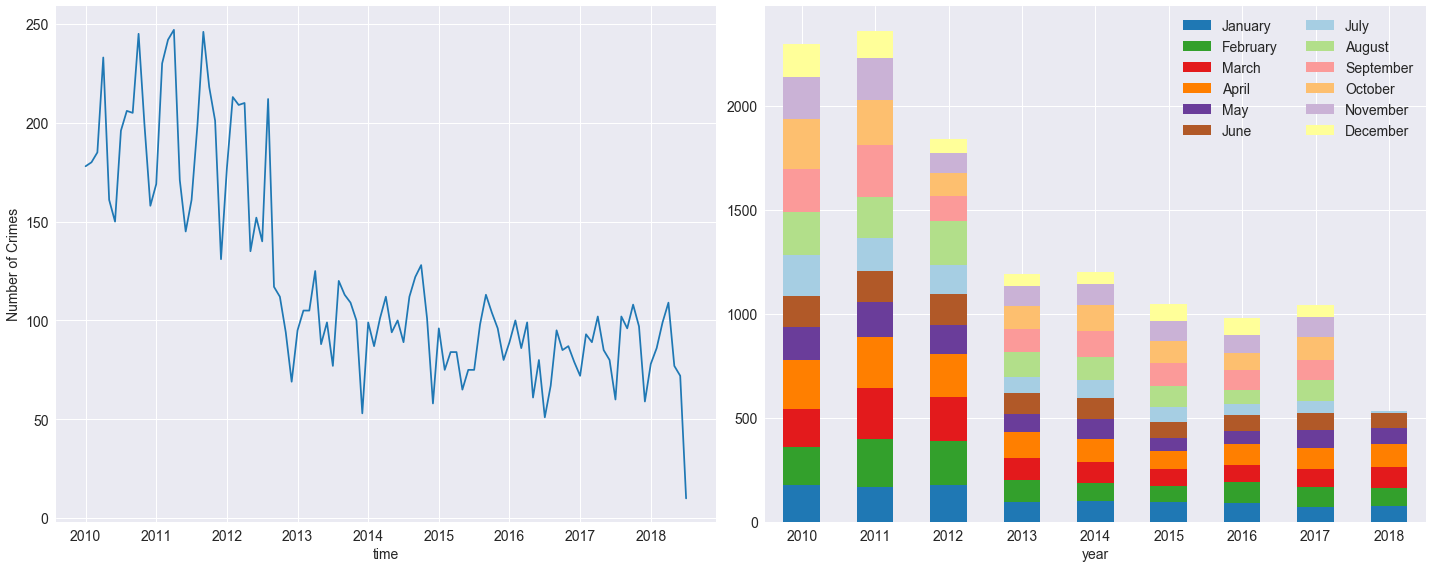

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

#plotting number of crimes resampled by month
c.resample('M').size().plot(ax=ax[0])
#plotting composition of crimes by month throughout the years
month_size = c.groupby(['year', 'month']).size()
month_size.unstack().plot(kind='bar', stacked=True, ax=ax[1], rot=0)

ax[0].set_ylabel('Number of Crimes')
ax[1].legend(month_names, ncol=2)
plt.tight_layout()
plt.show()

Despite the general decrease in crime, number of crimes per month appears to have some sort of periodicity. Months during the summer semester and December tend to have the least number of crimes. April consistently is among the highest per year, and the rest seem to be fairly evenly distributed.

Let's look a little closer at the proportion of yearly crimes in each month and how it has changed over the years.

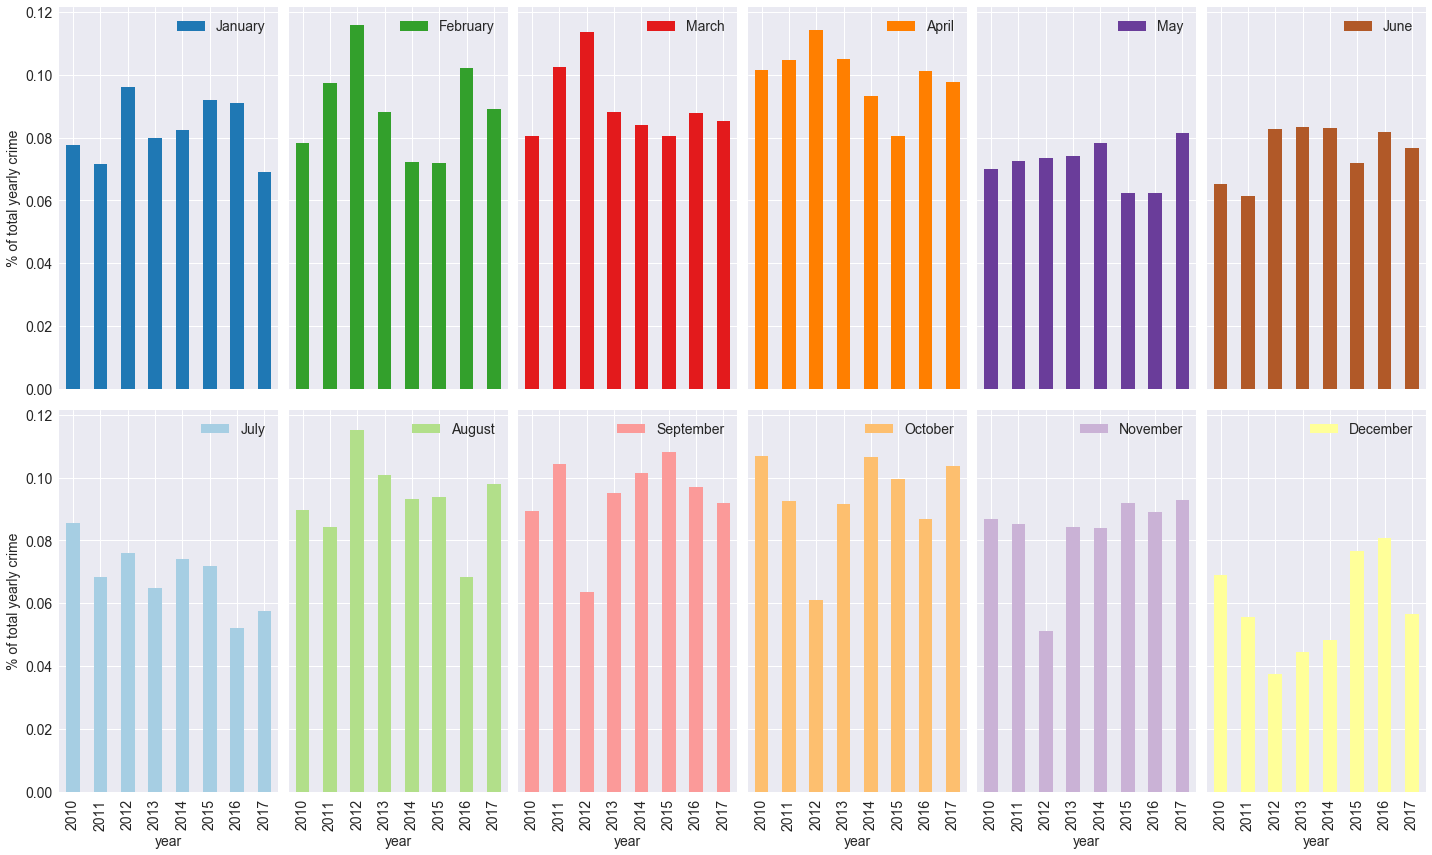

In [10]:
#getting counts per month
#dropping 2018 - incomplete so percentages are incorrect
month_percentages = month_size.unstack().drop(2018)
month_percentages.columns = month_names

#dividing number per month by year total for each year
for year in month_percentages.index:
    year_total = month_percentages.loc[year].sum()
    month_percentages.loc[year] = month_percentages.loc[year].apply(lambda x: x/year_total)

#plotting
ax = month_percentages.plot(kind='bar', subplots=True, layout=(2, 6),
                            figsize=(20, 12), sharey=True, legend=True, label='asdfasdf')
ax[0, 0].set_ylabel('% of total yearly crime')
ax[1, 0].set_ylabel('% of total yearly crime')
for row in ax:
    for plot in row:
        plot.set_title('')

plt.tight_layout()
plt.show()

The distribution of the proportion of crimes in each month appears to stay relatively consistent. This chart displays more clearly the dip in crime in the summer semester months.

2012 is particularly interesting - the spring semester months have a similar number of crimes to the years prior, but an increased proportion due to the drop in crimes overall. The overall drop for 2012 is attributed to the fall semester having a major decrease in crimes for this year. This is the first semester where I believe the Georgia Tech Police Department changed their reporting methods or drastically increased their policing presence, corresponding to the large dip in the crimes in the following years, shown in the aggregated crime over time charts above.

Let's look now at the correlations number of crimes per month has with other variables, starting with autocorrelation.

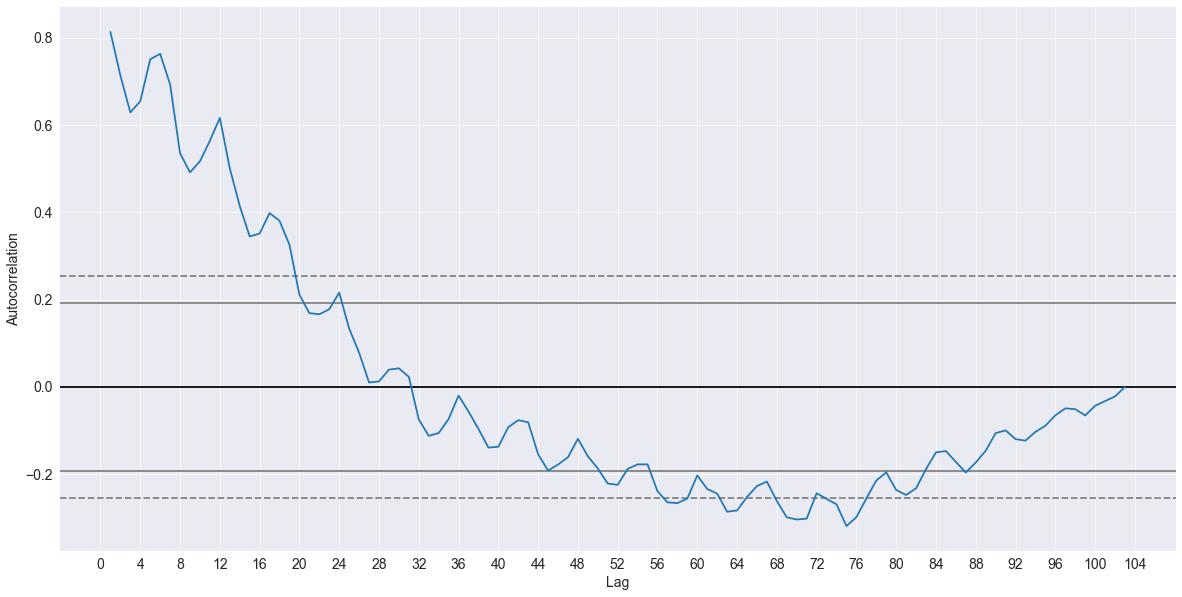

In [11]:
fig, ax = plt.subplots(figsize=(20,10))

#plotting autocorrelation of crimes per semester
pd.plotting.autocorrelation_plot(month_size, ax=ax)
plt.xticks(range(0, 105, 4))
plt.grid(color='w', linestyle='-', alpha=0.6)

plt.show()

This is an interesting autocorrelation plot. It seems to spike in intervals of 12, corresponding with the number of months per year. The solid grey horizontal line represents a 95% confidence band that the autocorrelation is nonzero. The dashed grey line represents a 99% confidence band. In particular, the autocorrelations with lags less than 20 are very statistically significant, so we should use these as predictors in our final model.

Let's now look at the correlations with other variables.

In [12]:
month_means = c.groupby(['year', 'month']).agg(np.mean)
month_means['num_crimes'] = month_size
month_means.columns

Index(['code', 'lat', 'long', 'day_of_year', 'day_of_month', 'day_of_week',
       'hour', 'enrollment', 'pop_total', 'pop_male', 'pop_female',
       'pop_under_5', 'pop_5_9', 'pop_10_14', 'pop_15_19', 'pop_20_24',
       'pop_25_34', 'pop_35_44', 'pop_45_54', 'pop_55_59', 'pop_60_64',
       'pop_65_74', 'pop_75_84', 'pop_over_84', 'inc_lesser_10', 'inc_10_15',
       'inc_15_25', 'inc_25_35', 'inc_35_50', 'inc_50_75', 'inc_75_100',
       'inc_100_150', 'inc_150_200', 'inc_greater_200', 'inc_median',
       'inc_mean', 'num_crimes'],
      dtype='object')

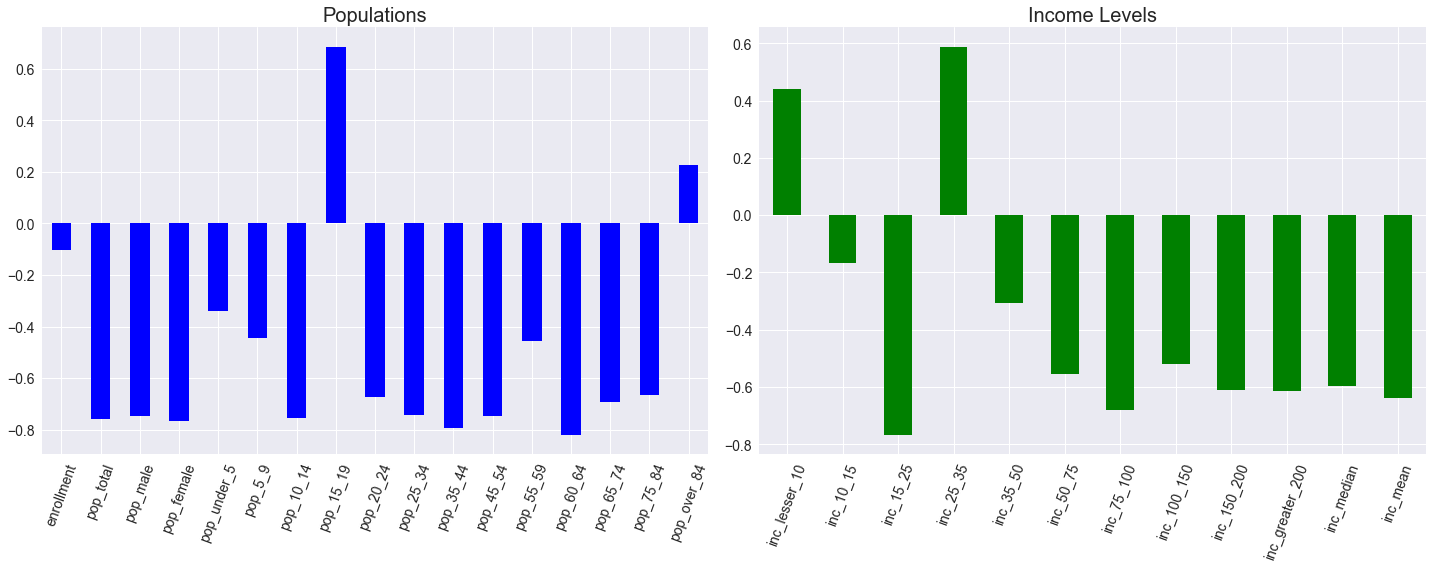

In [13]:
#finding values to be used for correlations
month_means = c.groupby(['year', 'month']).agg(np.mean)
month_means['num_crimes'] = month_size

#getting rid of irrelevant and categorical columns
month_means = month_means.iloc[:, 7:]

#finding final correlations
correlations = month_means.corr()['num_crimes'].drop('num_crimes')

#plotting
fig, ax = plt.subplots(1,2, figsize=(20,8))
correlations.iloc[:17].plot(kind='bar', color='b', ax=ax[0], title='Populations', rot=70)
correlations.iloc[17:29].plot(kind='bar', color='g', ax=ax[1], title='Income Levels', rot=70)

plt.tight_layout()
plt.show()

As expected, enrollment has a positive correlation with number of crimes despite the general decrease in crime throughout the years. Also, it appears that the proportion of the population from 15-19 years old plays a large part in number of crimes. We will want to use this as a feature for our predictions.

In terms of income levels, as expected, mean and median income have a fairly strong negative correlation with crime levels. It also appears that as the number of households with income levels less than $15,000 annually has a positive correlation with crime levels.

Now that we've looked at some basic correlations, it might be a good idea to look more in depth at the associations crime has with locations/times. Can we find certain rules that describe relations like whether it's less likely to have a crime in the late night at winter compared to the summer, due to the cold temperatures? The apriori algorithm and its association rules seem like the perfect fit.

In [14]:
def apriori(df, col1, col2):
    """
    takes in the crime dataframe and two column names
    returns a dataframe with the order 2 association rules
    indexed based on given column names
    """
    n = len(df)
    supports1 = df.groupby(col1).size()/n
    supports2 = df.groupby(col2).size()/n
    supports_combined = df.groupby([col1, col2]).size()/n
    confidences = {}
    lifts = {}
    
    for val1, val2 in supports_combined.index:
        s1 = supports1[val1]
        s2 = supports2[val2]
        sc = supports_combined[(val1, val2)]
        
        confidences[(val1, val2)] = sc / s1
        lifts[(val1, val2)] = sc / (s1*s2)
        
    confidences = pd.Series(confidences)
    lifts = pd.Series(lifts)
    associations = pd.concat([supports_combined, confidences, lifts], axis=1)
    associations.columns = ['support', 'confidence', 'lift']
    associations.index.names = [col1, col2]
    
    return associations


def plot_lift(df, ax, kind='line'):
    """
    takes in an associations dataframe output by apriori, matplotlib axes, and optional kind parameter
    plots the lift column
    returns matplotlib figure object
    """
    x = df.index.get_level_values(1)
    xlim = (x.min(), x.max())
    lift_fig = df['lift'].unstack(0).plot(kind=kind, xlim=xlim, ax=ax)
    ax.axhline(1, color='black')
    ax.set_ylabel('lift')
    
    return lift_fig

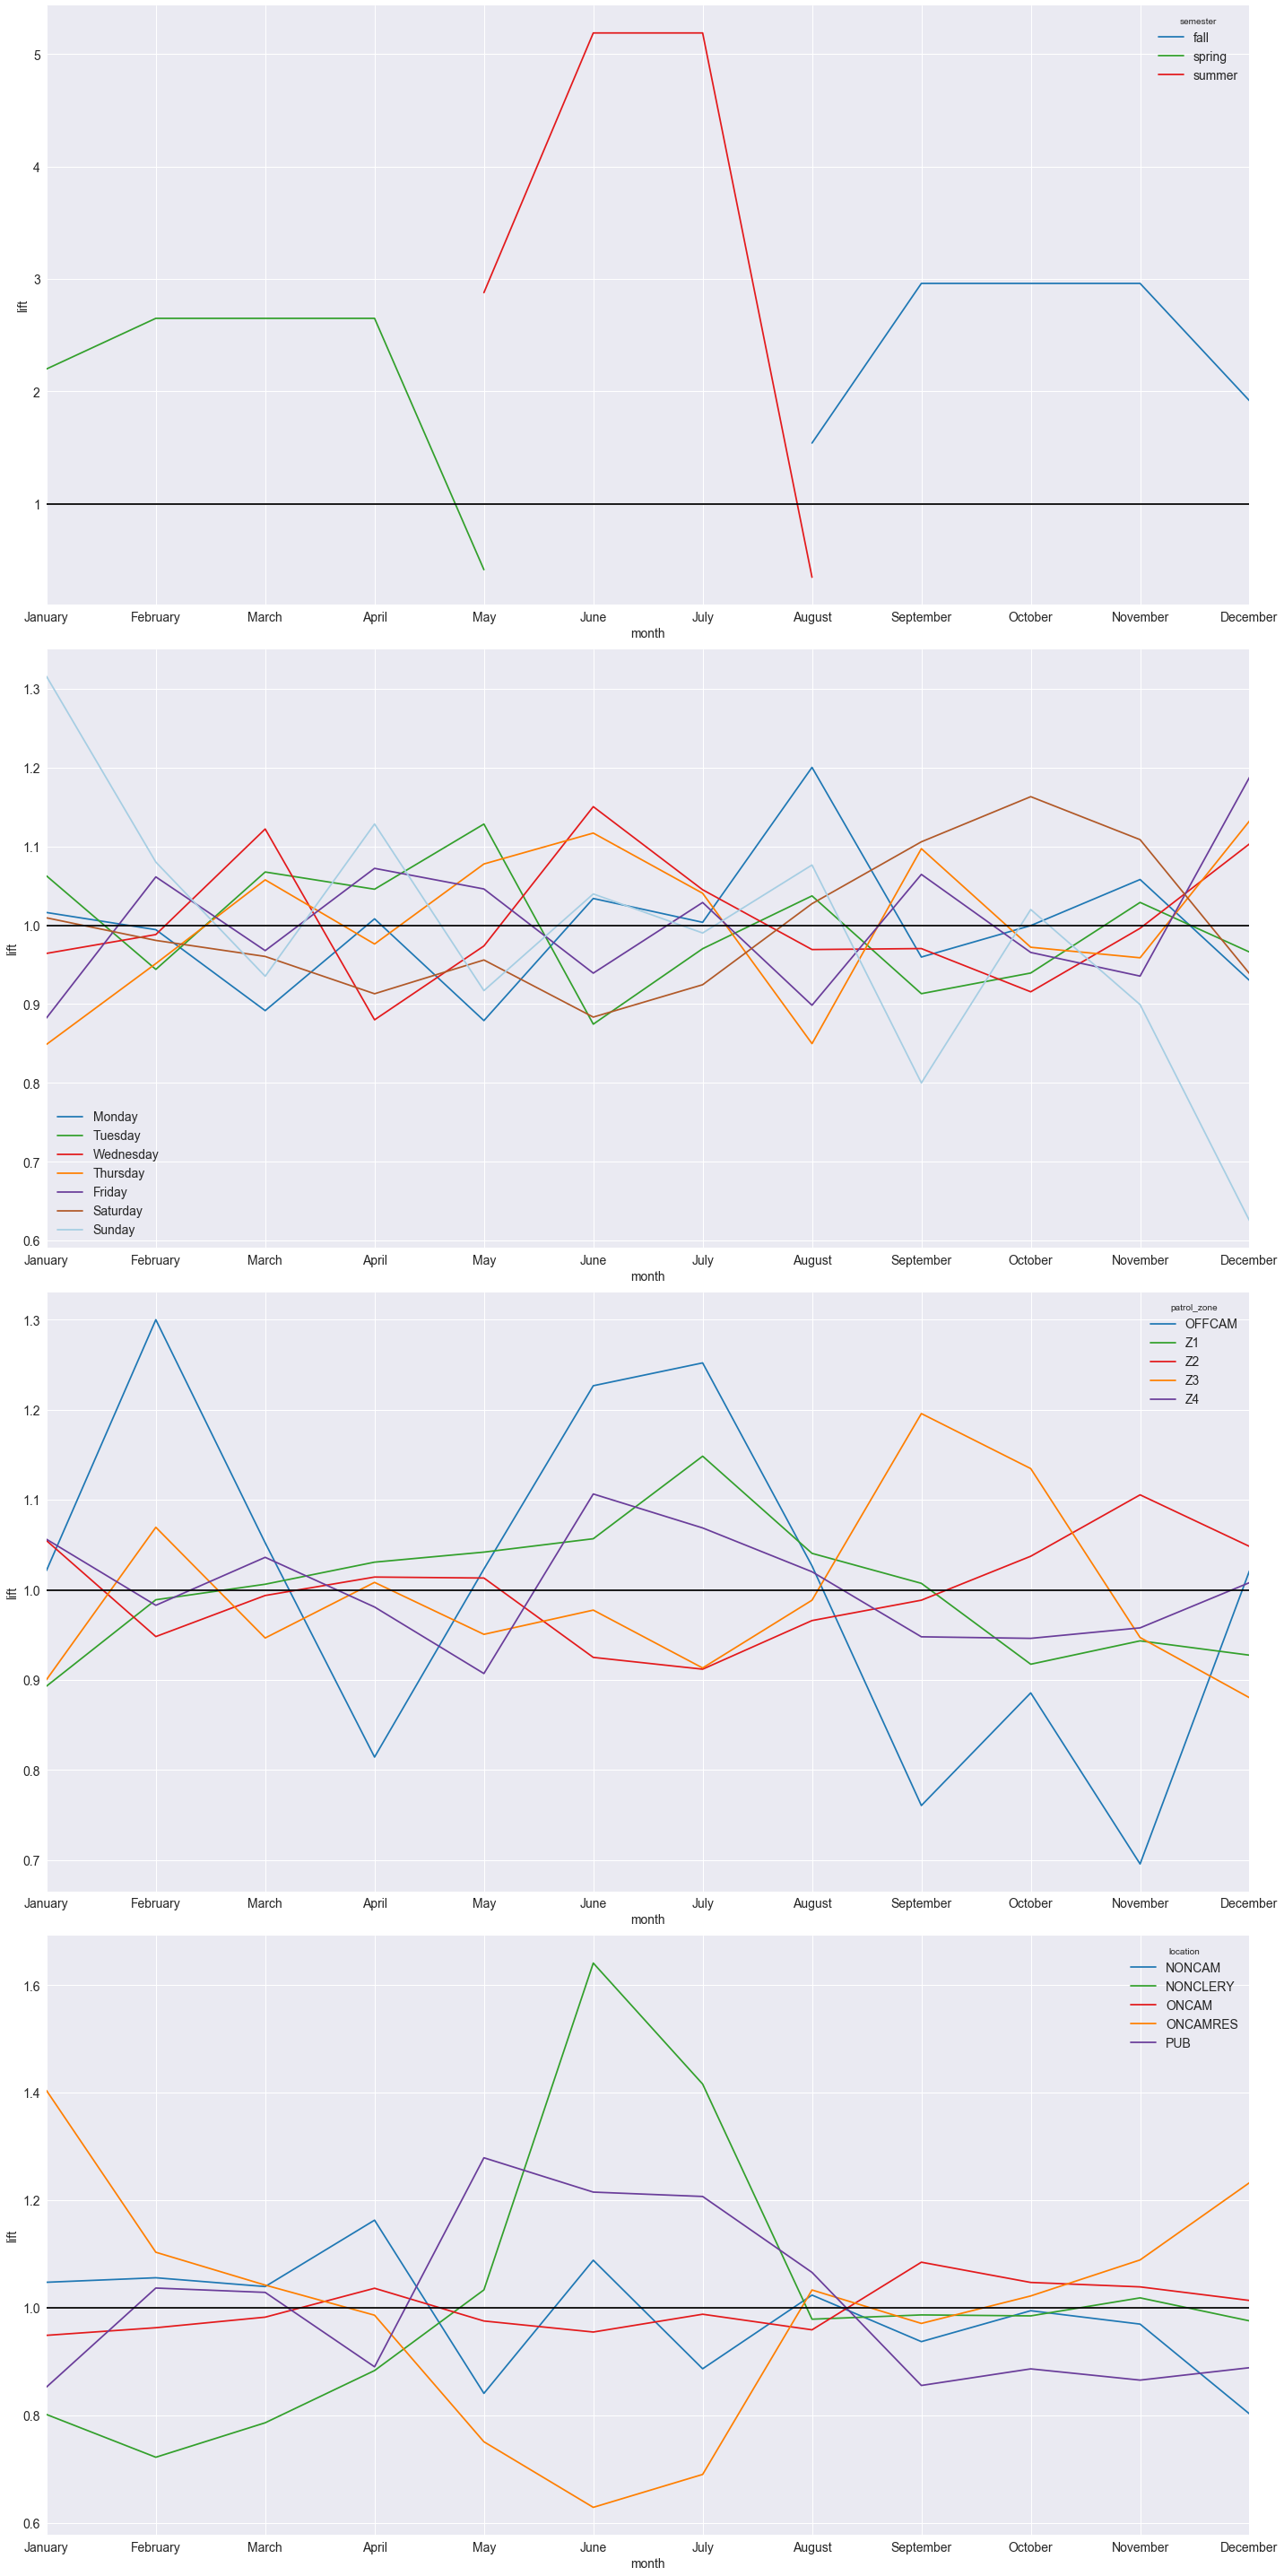

In [15]:
#plotting lift of association rules for semester with other categorical variables
fig, ax = plt.subplots(4, 1, figsize=(20, 40))

plot_lift(apriori(c, 'semester', 'month'), ax=ax[0])
plot_lift(apriori(c, 'day_of_week', 'month'), ax=ax[1])
plot_lift(apriori(c, 'patrol_zone', 'month'), ax=ax[2])
plot_lift(apriori(c, 'location', 'month'), ax=ax[3])

for a in ax:
    a.set_xticks(range(1, 13))
    a.set_xticklabels(month_names)
ax[1].legend(dow_names)

plt.tight_layout()
plt.show()

From these lift charts, the day of week vs month chart is most important to our analysis. If crimes are more likely on certain days, we can use the number of each day in a month as a feature for predicting total number of crimes. For example, it looks like crimes on Sundays are much more frequent in January and much less frequent in December. But is this result significant? Let's look a little closer at the results for this relationship.

                      support  confidence      lift
month   day_of_week                                
January Monday       0.011132    0.132004  1.016153
        Tuesday      0.011613    0.137702  1.062636
        Wednesday    0.011052    0.131054  0.964256
        Thursday     0.010492    0.124406  0.848819
        Friday       0.013135    0.155745  0.882322
        Saturday     0.014256    0.169041  1.009394
        Sunday       0.012654    0.150047  1.315655
                       support  confidence      lift
month    day_of_week                                
December Monday       0.006647    0.120815  0.930023
         Tuesday      0.006888    0.125182  0.966021
         Wednesday    0.008249    0.149927  1.103118
         Thursday     0.009130    0.165939  1.132193
         Friday       0.011533    0.209607  1.187456
         Saturday     0.008650    0.157205  0.938721
         Sunday       0.003924    0.071325  0.625393


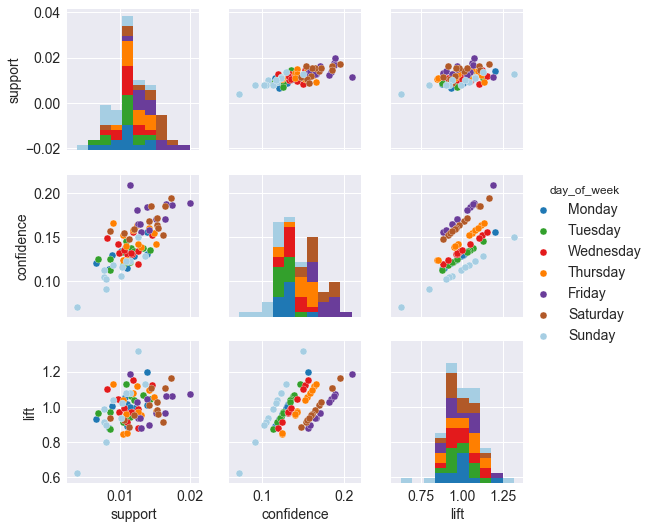

In [16]:
f = apriori(c, 'month', 'day_of_week')
f.index = f.index.set_levels([month_names, dow_names])
print(f.head(7))
print(f.tail(7))
f = f.reset_index()
sns.pairplot(f, vars=['support', 'confidence', 'lift'], hue='day_of_week')
plt.show()

As we might expect, support is evenly distributed among all month and day of week combinations, apart from Sunday. Among all the scatter plots, there are two light blue points that tend to deviate from the main cluster. These correspond to the Sunday in December and in January. We will want to look further into this.


Let's do a chi square test of homogeneity to determine if these differences between days are statistically significant.

We will perform one test for each day of the week. Each test will have the following hypotheses with alpha = 0.05:

H0: For each month, there is no difference in proportion of crimes on this day

Ha: There is a difference in the proportion of crimes on this day in at least one of the months

In [17]:
#finding frequencies of crimes by day for each semester
dow_frequencies = c.groupby(['month', 'day_of_week']).size().unstack()
dow_frequencies.columns = dow_names
dow_frequencies.index = month_names

dow_frequencies

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
January,139,145,138,131,164,178,158
February,151,143,157,163,219,192,144
March,139,166,183,186,205,193,128
April,173,179,158,189,250,202,170
May,107,137,124,148,173,150,98
June,128,108,149,156,158,141,113
July,112,108,122,131,156,133,97
August,174,150,147,139,177,192,137
September,138,131,146,178,208,205,101
October,144,135,138,158,189,216,129


Now that we have crime counts per day per month, we will need to calculate expected number of crimes per day per month, if we assume the null hypothesis to be true.

In [18]:
#calculating the contingency matrix
contingency = dow_frequencies.copy()
contingency['total'] = contingency.apply(np.sum, axis='columns')
contingency.loc['total'] = contingency.apply(np.sum, axis='rows')
contingency.iloc[:-1, :-1] = 1 

#finding expected number of crimes for each entry, assuming the null hypothesis
for month in range(12):
    for day in range(7):    
        semester_tot = contingency.iloc[month, -1]
        day_tot = contingency.iloc[-1, day]
        overall_tot = contingency.iloc[-1, -1]
        contingency.iloc[month, day] *= semester_tot * day_tot / overall_tot
        
contingency

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,total
January,136.790485,136.453148,143.115569,154.332052,185.873138,176.343345,120.092263,1053
February,151.859523,151.485023,158.881387,171.333494,206.349191,195.769582,133.321800,1169
March,155.886593,155.502162,163.094666,175.876982,211.821240,200.961076,136.857280,1200
April,171.605158,171.181964,179.540045,193.611245,233.179881,221.224652,150.657056,1321
May,121.721448,121.421272,127.349752,137.330610,165.397085,156.917107,106.862726,937
June,123.799936,123.494634,129.524347,139.675637,168.221368,159.596588,108.687490,953
July,111.588819,111.313631,116.748598,125.898606,151.628704,143.854637,97.967003,859
August,144.974531,144.617011,151.678039,163.565593,196.993753,186.893801,127.277271,1116
September,143.805382,143.450745,150.454829,162.246516,195.405094,185.386593,126.250841,1107
October,144.065193,143.709915,150.726654,162.539644,195.758129,185.721528,126.478936,1109


We can now perform our chi-square test for each day.

In [19]:
#performing chi-square test for each day
p_values = stats.chisquare(dow_frequencies, contingency.iloc[:-1, :-1])[1]
print('p-value for each day:\n')
for day, p in zip(dow_names, p_values):
    print('{}: {}'.format(day, p.round(5)))

p-value for each day:

Monday: 0.46754
Tuesday: 0.70114
Wednesday: 0.45871
Thursday: 0.1863
Friday: 0.23682
Saturday: 0.18849
Sunday: 0.00027


As expected, Sunday has the lowest p-value by far. We only fail to reject the null hypothesis on Sunday, so we will use number of Sundays per month as a feature for our predictions. 